In [1]:
if length(LOAD_PATH)<4
    addprocs(3)
    push!(LOAD_PATH,"/Users/wrsweeney/Box Sync/Research/SALT")
end

using SALT_1d
using SALT_1d_Parallel
using PyPlot

In [ ]:
inputs = processInputs()
N = 5
;

In [ ]:
tic()
S1,r = computeS_parallel(inputs; N=N, dispOpt=false, fileName = "S1.dat")
toc()
tic()
wait(r)
toc()
;

In [ ]:
tic()
S2 = SharedArray(Complex128, (2,2,length(inputs["k"]),N), pids=workers())
computeS_parallel!(S2, inputs; N=N, dispOpt=false)
toc()
tic()
while S2[1,1,1,1]==0
    pause(.01)
end
toc()
;

In [ ]:
tic()
S3 = computeS(inputs; N=N, dispOpt = false, fileName = "S3.dat")
toc()
;

In [ ]:
#verify computeCFs
inputs = processInputs()
η,u = computeCFs(inputs,inputs["k₀"]+.1im,10, bc = "out")
β,v = computeCFs(inputs,inputs["k₀"]+.1im,10, bc = "in")

figure(1)
title("Outgoing TCF evals (x's) and incoming TCF evals (o's) for non-uniformly pumped cavity.")
plot(real(β),imag(β),"o")
plot(real(η),imag(η),"x")

figure(2)
title("TCF states, purely outgoing, at complex k+ig. Expect exponential decay.")
plot(abs2(u))

figure(3)
title("TCF states, purely incoming, at complex k+ig. Expect exponential growth.")
plot(abs2(v))
;

In [ ]:
#verify computePolesL

inputs = processInputs()

nD = 10
nPoles = 3
D = linspace(-.25,0.25,nD)

kp = NaN*zeros(Complex128,nD,nPoles)
ψp = NaN*zeros(Complex128,nD,inputs["N_ext"],nPoles)
for d in 1:nD
    inputs["D₀"] = D[d]
    kp[d,:],ψp[d,:,:] = computePolesL(inputs, inputs["k₀"], nPoles; F=1.)
end

figure(1)
title("Trajectories of poles as n'' is varied uniformly. Circle indicates n''=0.")
plot(real(kp),imag(kp),"-x")
plot(real(kp[ceil(Int,nD/2),:]),imag(kp[ceil(Int,nD/2),:]),"o")
grid(true)

figure(2)
title("Wavefunctions associated with a pole at varying n''.")
plot(inputs["x_ext"],abs2(ψp[:,:,1]'))
;

In [ ]:
#verify computeZerosL

inputs = processInputs()

nD = 10
nZeros = 3
D = linspace(-.25,0.25,nD)

kz = NaN*zeros(Complex128,nD,nZeros)
ψz = NaN*zeros(Complex128,nD,inputs["N_ext"],nZeros)
for d in 1:nD
    inputs["D₀"] = D[d]
    kz[d,:],ψz[d,:,:] = computeZerosL(inputs, inputs["k₀"], nZeros; F=1.)
end

figure(1)
title("Trajectories of zeros as n'' is varied uniformly. Square indicates n''=0.")
plot(real(kz),imag(kz),"-o")
plot(real(kz[ceil(Int,nD/2),:]),imag(kz[ceil(Int,nD/2),:]),"s")
grid(true)

figure(2)
title("Wavefunctions associated with a zero at varying n''.")
plot(inputs["x_ext"],abs2(ψz[:,:,1]'))
;

In [ ]:
#verify computePolesNL1

inputs = processInputs()

nD = 10
D = linspace(0,0.4,nD)
nPoles = 5

kp_init, ψp_init = computePolesL(inputs,inputs["k₀"],nPoles;F=1.)

kp = NaN*zeros(Complex128,nD,nPoles)
ψp = NaN*zeros(Complex128,nD,inputs["N_ext"],nPoles)
η = 0

for n in 1:nPoles
    for d in 1:nD
        if d/3==round(d/3)
            println([n,d])
        end
        inputs["D₀"] = D[d]
        if d==1
            kp[d,n],ψp[d,:,n],η,conv = computePolesNL1(inputs, kp_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kp[d,n],ψp[d,:,n],η,conv = computePolesNL1(inputs, kp[d-1,n] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, η_init = η, u_init = ψp[d-1,:,n] )
        end
    end
end

figure(1)
plot(real(kp),imag(kp),"-x")

figure(2)
plot(abs2(ψp[:,:,1])')    
;

In [ ]:
#verify computeZerosNL1

inputs = processInputs()

nD = 10
D = linspace(0,-0.4,nD)
nZeros = 5

kz_init, ψz_init = computeZerosL(inputs,inputs["k₀"],nZeros;F=1.)

kz = NaN*zeros(Complex128,nD,nZeros)
ψz = NaN*zeros(Complex128,nD,inputs["N_ext"],nZeros)
β = 0

for n in 1:nZeros
    for d in 1:nD
        if d/3==round(d/3)
            println([n,d])
        end
        inputs["D₀"] = D[d]
        if d==1
            kz[d,n],ψz[d,:,n],β,conv = computeZerosNL1(inputs, kz_init[n]; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50)
        else
            kz[d,n],ψz[d,:,n],β,conv = computeZerosNL1(inputs, kz[d-1,n] ; F=1., dispOpt = false ,tol = .7, max_count = 15, max_iter = 50, β_init = β, v_init = ψz[d-1,:,n] )
        end
    end
end

figure(1)
plot(real(kz),imag(kz),"-x")

figure(2)
plot(abs2(ψz[:,:,1])')    
;

In [ ]:
figure(1)
plot(real(kp[1,:]),imag(kp[1,:]),lw=2.,"x",mew=2)
plot(real(kp[end,:]),imag(kp[end,:]),lw=2.,"^",mew=2)
plot(real(kp),imag(kp),lw=2.,"b")
plot([0,100],[0,0],"--",color=[.8,.8,.8])
plot(inputs["k₀"]*[1,1],[-100,100],"-",color=[.5,.5,.5])
xlim([41,47])
ylim([-.7,.7])

figure(2)
plot(real(kz[1,:]),imag(kz[1,:]),lw=2.,"ro",mew=2)
plot(real(kz[end,:]),imag(kz[end,:]),lw=2.,"v",mew=2,color="r")
plot(real(kz),imag(kz),lw=2.,"r")
plot([0,100],[0,0],"--",color=[.8,.8,.8])
plot([0,100],-.65*[1,1],"-",color=[.5,.5,.5])
plot(inputs["k₀"]*[1,1],[-100,100],"-",color=[.5,.5,.5])
xlim([41,47])
ylim([-.7,.7])

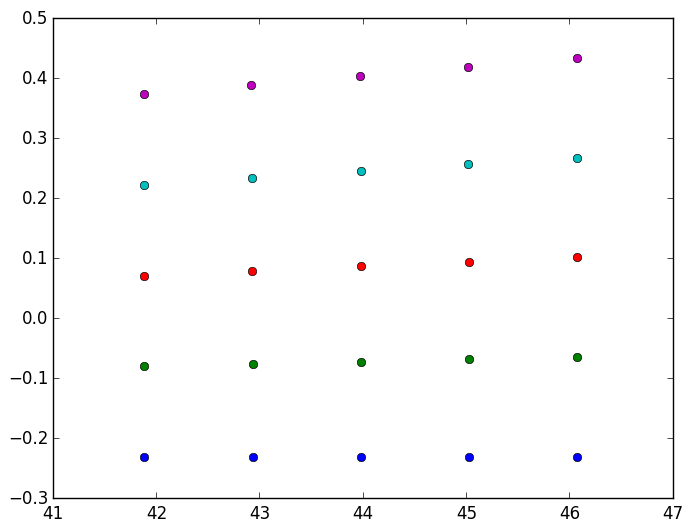

In [2]:
# verify computePolesNL2

inputs = processInputs()

nD = 5
D = linspace(0,0.4,nD)

kpp = Array(Any,nD)

for d in 1:nD
    inputs["D₀"] = D[d]
    kpp[d] = computePolesNL2_parallel(inputs, inputs["k₀"], (2.5,1.4); Nq=150, nPoles=7, F=1., R_min = .01)
end

for d in 1:nD
    plot(real(kpp[d]),imag(kpp[d]),"o")
end
;

In [ ]:
#verifying that computePolesNL1 and computePolesNL2 agree

figure(1)
plot(real(kp),imag(kp),"-x")

for d in 1:nD
    plot(real(kpp[d]),imag(kpp[d]),"o", mfc = "none")
end

In [ ]:
# verify computeZerosNL2

inputs = processInputs()

nD = 10
D = linspace(0,-0.4,nD)

kzz = Array(Any,nD)

for d in 1:nD
    inputs["D₀"] = D[d]
    kzz[d] = computeZerosNL2(inputs, inputs["k₀"], (2.75,.4); Nq=150, nZeros=7, F=1., R_min = .01)
end

for d in 1:nD
    plot(real(kzz[d]),imag(kzz[d]),"o")
end
;

In [ ]:
#verifying that computeZerosNL1 and computeZerosNL2 agree

figure(1)
plot(real(kz),imag(kz),"-x")

for d in 1:nD
    plot(real(kzz[d]),imag(kzz[d]),"o", mfc = "none")
end

In [ ]:
#verify solve_scattered linear

inputs = processInputs()
inputs["a"] = [1,0]
inputs["D₀"] = 0.015
inputs["Γ"][2]   = 5
inputs["Γ_ext"][2+2] = inputs["Γ"][2]
inputs["Γ"][4]   = 5
inputs["Γ_ext"][4+2] = inputs["Γ"][4]
k = 43.16

ψL = solve_scattered(inputs,k; F=1., truncate = true)

figure(1)
plot(inputs["x"],real(ψL))

figure(2)
plot(inputs["x"],imag(ψL))

figure(3)
plot(inputs["x"],abs2(ψL))
;

In [ ]:
#verify solve_scattered nonlinear

inputs = processInputs()
inputs["a"] = [1,0]
inputs["D₀"] = 0.015
inputs["Γ"][2]   = 5
inputs["Γ_ext"][2+2] = inputs["Γ"][2]
inputs["Γ"][4]   = 5
inputs["Γ_ext"][4+2] = inputs["Γ"][4]
k = 43.16

ψR = solve_scattered(inputs,k; F=1., truncate = true, isNonLinear = true, dispOpt = true)

figure(1)
plot(inputs["x"],real(ψR))

figure(2)
plot(inputs["x"],imag(ψR))

figure(3)
plot(inputs["x"],abs2(ψR))
;

In [ ]:
# compare nonlinear and linear scattering
plot(inputs["x"],abs2(ψL),"b")
plot(inputs["x"],abs2(ψR),"r")
;

In [ ]:
#verify S-matrix linear
inputs = processInputs()

S = computeS(inputs; N=1, isNonLinear = false, F=1., dispOpt = true)
SL = S[:,:,:,end]

figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(SL[1,1,:]),"r")
plot(inputs["k"],abs2(SL[2,1,:]),"b")
plot(inputs["k"],abs2(SL[1,1,:])+abs2(S[2,1,:])-1,"k")
;

In [ ]:
inputs = processInputs()
inputs["a"] = [1.,0.]

r = SALT_1d.Core.whichRegion(inputs["x"],inputs["∂"])
F = inputs["F"][r]
loss1 = NaN*zeros(Float64,length(inputs["k"]))
loss2 = copy(loss1)

for k_ind = 1:length(inputs["k"])
    k = inputs["k"][k_ind]
    ψ = solve_scattered(inputs, k; truncate = true)
    ɛ = inputs["ɛ"][r]+inputs["D₀"]*F*inputs["γ⟂"]/(k-inputs["k₀"]+1im*inputs["γ⟂"])

    loss1[k_ind] = abs2(S[1,1,k_ind])+abs2(S[2,1,k_ind])-1
    loss2[k_ind] = inputs["k"][k_ind]*real(SALT_1d.Core.trapz(-imag(ɛ).*abs2(ψ),inputs["dx"]))
end

title(L"Gain as $r^2+t^2-1$ (b-) and bulk gain computed via $\psi$ (r--)")
plot(inputs["k"],loss1,"b"  ,lw = 1.5)
plot(inputs["k"],loss2,"--r",lw = 2.)
;

In [ ]:
#verify S-matrix nonlinear
inputs = processInputs()

S = computeS(inputs; N=10, isNonLinear = true, F=1., dispOpt=true)
SNL = S[:,:,:,end]

figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(S[1,1,:]),"r")
plot(inputs["k"],abs2(S[2,1,:]),"b")
plot(inputs["k"],abs2(S[1,1,:])+abs2(S[2,1,:])-1,"k")
;

In [ ]:
figure(1)
title("Red: reflection coefficient. Blue: transmission coefficient. Black: Gain")
plot(inputs["k"],abs2(SL[1,1,:]),"r--")
plot(inputs["k"],abs2(SL[2,1,:]),"b--")
plot(inputs["k"],abs2(SL[1,1,:])+abs2(S[2,1,:])-1,"k--")
plot(inputs["k"],abs2(SNL[1,1,:]),"r",lw=1.5)
plot(inputs["k"],abs2(SNL[2,1,:]),"b",lw=1.5)
plot(inputs["k"],abs2(SNL[1,1,:])+abs2(S[2,1,:])-1,"k",lw=1.5)
;

In [ ]:
# # TEST SPA scattered
# inputs["a"] = 1.
# inputs["D₀"] = .2
# ψ₊,ψ₋,(z₊,z₋,φ₊,φ₋,η,u) = solve_SPA(inputs, real(ω1[1]), z₀₊=.15im, z₀₋=1.5im)

# plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
# hold(true)
# plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]))

In [ ]:
# # TEST SPA Lasing
# a = copy(inputs["a"])
# inputs["a"] = 0.
# inputs["D₀"] = D2
# ψ₊,ψ₋,dummy = solve_SPA(inputs, real(ω1[1]),z₀₊=.0001im,z₀₋=.0001im)

# plot(inputs["x"],abs2(ψ₊[inputs["x_inds"]]))
# hold(true)a
# plot(inputs["x"],abs2(ψ₋[inputs["x_inds"]]));

In [ ]:
# # TEST LASING SOLVER
# ψ₊ = 1im*ψ₊/exp(1im*angle(ψ₊[1]))
# ψ₋ = 1im*ψ₋/exp(1im*angle(ψ₋[1]))
# ψ,ω = solve_lasing(inputs, inputs["D₀"], ψ_init=ψ₊,ω_init = real(ω1[1]), inds = 14)
# ω

In [ ]:
S2 = SharedArray(abspath("S1.dat"),Complex128,(2,2,length(inputs["k"]),2))

In [ ]:
fid = open("S1.dat","r")
S3 = read(fid,Complex128,(2,2,2,2))

In [ ]:
[rand(5,2) rand(5,4)]

In [ ]:
10 + (1:5)